# AI-LAB LESSON 6: Deep Reinforcement Learning

In this lesson we will use the CartPole environment and we will see how to create and work with a neural network using Kears on top of Tensorflow.

## CartPole
The environment used is **CartPole** (taken from the book of Sutton and Barto as visible in the figure)

![Cartpole](images/cartpole.jpg)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [1]:
import os, sys, tensorflow.keras, random, numpy
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm
from collections import deque
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

The **state** of environment is represented as a tuple of 4 values: 
- *Cart Position* range from -4.9 to 4.8
- *Cart Velocity* range from -inf to +inf
- *Pole Angle* range from -24 deg to 24 deg
- *Pole Velocity* range from -inf to +inf

The **actions** allowed in the environment are 2:
- *action 0*: push cart to left
- *action 1*: push cart to right

The **reward** is 1 for every step taken, including the termination step.

In [2]:
env = gym.make("CartPole-v1")
state = env.reset()
print("STARTING STATE: {}".format(state))
print("\tCart Position: {}\n\tCart Velocity {}\n\tPole Angle {} \n\tPole Velocity {}".format(state[0], state[1], state[2], state[3]))

print("\nPOSSIBLE ACTIONS: ", env.action_space.n)

new_state, rew, done, _ = env.step(0)
print("push left --> s' {} r {} done {} \n".format(new_state, rew, done))

STARTING STATE: [-0.02781234  0.03740394  0.01390751 -0.0220598 ]
	Cart Position: -0.02781233621278092
	Cart Velocity 0.037403938063966566
	Pole Angle 0.013907514241426527 
	Pole Velocity -0.022059803846701587

POSSIBLE ACTIONS:  2
push left --> s' [-0.02706426 -0.15791467  0.01346632  0.27497845] r 1.0 done False 



Finally, we still have the standard functionalities of a Gym environment:
- step(action): the agent performs action from the current state. Returns a tuple (new_state, reward, done, info) where:
    - new_state: is the new state reached as a consequence of the agent's last action
    - reward: the reward obtained by the agent in this step
    - done: True if the episode is terminal, False otherwise
    - info: not used, you can safely discard it

- reset(): the environment is reset and the agent goes back to the starting position. Returns the initial state id

## Neural network with Kears
**Keras** is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, R, Theano, or PlaidML. Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular, and extensible.

![Network](images/neural_networks.png)

With **Keras** you can easly create a neural network with the **Sequential** module. Before training a neural netowrk you must compile it, selecting the loss function and the optimizer. In our lab session we will use the *mean_squared_error* for the loss function and the *adam* optimizer, that is a standard configuration for the DQN approach.

In [3]:
input_layer = 3
layer_size = 5
output_layer = 2

model = Sequential()
model.add(Dense(layer_size, input_dim=input_layer, activation="relu")) #input layer + hidden layer #1
model.add(Dense(layer_size, activation="relu")) #hidden layer #2
model.add(Dense(layer_size, activation="relu")) #hidden layer #3
model.add(Dense(layer_size, activation="relu")) #hidden layer #4
model.add(Dense(layer_size, activation="relu")) #hidden layer #5
model.add(Dense(output_layer, activation="linear")) #output layer

model.compile(loss="mean_squared_error", optimizer='adam') #loss function and optimzer definition

2022-11-14 17:44:28.996572: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-14 17:44:28.996821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 17:44:28.997686: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In Keras you can compute the output of a network with the **predict** function, that requires in input the values of the input layer nodes and returns the corresponding values of the output layer.

In [4]:
input_network = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
output_network = model.predict(np.array([input_network]))
print("Input network: {}".format(input_network))
print("network Prediction: {}".format(output_network[0]))

2022-11-14 17:44:29.080380: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-14 17:44:29.096859: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2594035000 Hz


Input network: [0.44873560333713214, 0.9048683980967359, 0.5548191510014102]
network Prediction: [0. 0.]


To train a network in Keras we must use the function **fit**, that take as input:
- *input*: the input of the network that we want to train
- *expected_output*: the target output (i.e., the desired output)
- *epochs*: the number of iteration for the backpropagation (in DQN this value is always 1).

In [5]:
input_network = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]
expected_output = [0, 0]

print("Prediction 'before' training:")
print(model.predict(np.array([input_network])))

#model.fit(np.array([input_network]), np.array([expected_output]), epochs=1000, verbose=0)

print("\nPrediction 'after' training:")
print(model.predict(np.array([input_network])))

Prediction 'before' training:
[[0. 0.]]

Prediction 'after' training:
[[0. 0.]]


Finally, remember that for all the methods (*fit*, *predict*, ...) keras requires as input a numpy array of arrays, for example you must convert your state in the correct **shape**.  Kears will return, in the same way, an array of array, so to extract the corresponding output layer you must select the first element.

In [6]:
state = np.array([0, 0, 0])
#model.predict(state) #will give you an error
state = state.reshape(1, 3)
print(state)
print("Prediction:", model.predict(state)[0])

[[0 0 0]]
Prediction: [0. 0.]


## Assignment: Q-Learning

Your assignement is to implement all the necessary functions for a deep q-learning algorithm. In particular you must implement the following functions: *create_model*, *train_model* and *DQN*.

#### Hint:
For the experience replay buffer you can use the python data structure *dequeue*, defining the maximum length allowed. With the *random.sample(replay_buffer, size)* function you can sample *size* element from the queue:

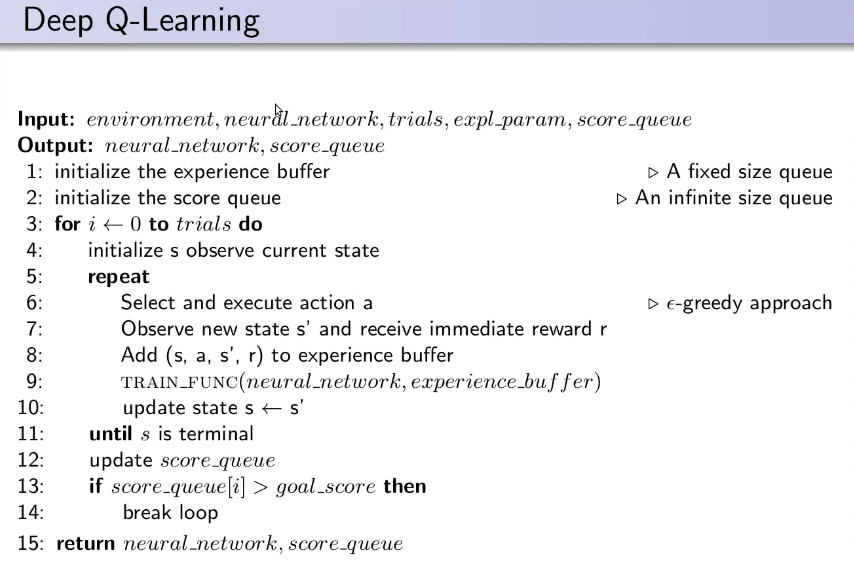

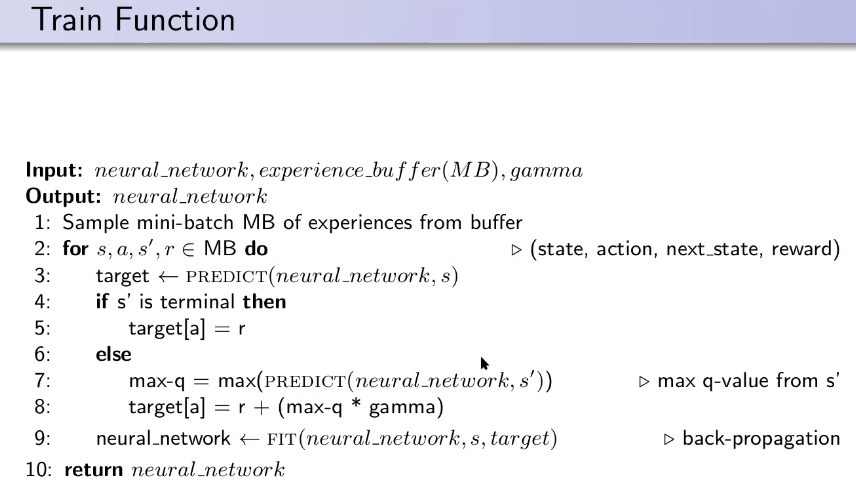

In [7]:
replay_buffer = deque(maxlen=10000)
for _ in range(100): replay_buffer.append(random.uniform(0, 1))

samples = random.sample(replay_buffer, 3) 
print("Get 3 element from replay_buffer:", samples)

Get 3 element from replay_buffer: [0.0994128618546326, 0.3356134772195115, 0.04238922835458159]


In [8]:
def create_model(input_size, output_size, hidden_layer_size, hidden_layer_number):
    """
    Create the neural network model with the given parameters
    
    Args:
        input_size: the number of nodes for the input layer
        output_size: the number of nodes for the output layer
        hidden_layer_size: the number of nodes for each hidden layer
        hidden_layer_number: the number of hidden layers
        
    Returns:
        model: the corresponding neural network
    """
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=input_size, activation="relu")) #input layer + hidden layer #1
    for _ in range(hidden_layer_number):
        model.add(Dense(hidden_layer_size, activation="relu")) #hidden layer #2
    model.add(Dense(output_size, activation="linear")) #output layer
    model.compile(loss="mean_squared_error", optimizer='adam')
    return model

In [9]:
def train_model(model, target_model, memory, batch_size, gamma=0.99):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        model: the neural network model to train
        memory: the memory array on wich perform the training
        batch_size: the size of the batch sampled from the memory
        gamma: gamma value, the discount factor for the Bellman equation
    """    
    batch_size = min(batch_size, len(memory))
    #if len(memory) < batch_size: return model
    
    
    minibatch = random.sample(memory, batch_size)
    verbose = 0
    
    for i,(state,action,new_state,reward,is_terminal) in enumerate(minibatch):
        s = np.array(state).reshape(1,-1)
        qvalue = model.predict(s)[0]
        qvalue[action] = reward
        if not is_terminal:
            new_qvalue = target_model.predict(np.array(new_state).reshape(1,-1))[0]
            max_qvalue = np.max(new_qvalue)
            qvalue[action] += max_qvalue * gamma
        verbose = ( i ==0 or i == len(minibatch)-1 )
        model.fit( s, qvalue.reshape(1,-1), epochs=1, verbose=verbose)
    
    # Vectorialized implementation ( doesn't converge, lower lr ?)
    #states = [exp[0] for exp in minibatch]
    #actions = (exp[1] for exp in minibatch)
    #new_states = [exp[2] for exp in minibatch]
    #rewards = [exp[3] for exp in minibatch]
    #not_terminals = [0 if exp[4] else 1 for exp in minibatch]
    
    #qvalues = model.predict(np.array(states)) 
    #new_qvalues = target_model.predict(np.array(new_states))
    #max_qvalues = np.max(new_qvalues, axis=1)
    
    #target_rewards = rewards + (not_terminals * max_qvalues * gamma)
    #for i,(action,target_reward) in enumerate(zip(actions,target_rewards)):
    #    qvalues[i][action] = target_reward
    #model.fit( np.array(states),np.array(qvalues),epochs=1)
       
    return model

In [10]:
def DQN(environment, nn, trials, goal_score, batch_size, epsilon_decay=0.9995):
    """
    Performs the Q-Learning algorithm for a specific environment on a specific neural network model
    
    Args:
        environment: OpenAI Gym environment
        neural_network: the neural network to train
        trials: the number of iterations for the training phase
        goal_score: the minimum score to consider the problem 'solved'
        batch_size: the size of the batch sampled from the memory
        epsilon_decay: the decay value of epsilon for the eps-greedy exploration
        
    Returns:
        score_queue: 1-d dimensional array of the reward obtained at each trial step
    """
            
    epsilon = 1.0; 
    epsilon_min = 0.01
    score = 0;
    score_queue = []
    replay_buffer = deque(maxlen=10000)
    update_target = 4
    target_nn = clone_model(nn)
    
    for trial in range(trials):       
        total_reward = 0
        state = environment.reset()   
        verbose = 1
        steps = 0
        while True:
            #print(state)
            #choose action
            action = environment.action_space.sample()
            if np.random.random() >= epsilon:
                qvalues = nn.predict(state.reshape(1,4))
                action = np.argmax(qvalues)
            
            # execute action
            new_state, reward, is_terminal, _ = environment.step(action)
            
            # save experience
            replay_buffer.append( [state, action, new_state, reward, is_terminal] )
            # train 
            nn = train_model(nn, target_nn, replay_buffer, batch_size)
            
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            # prepere for new trial
            state = new_state
            total_reward += reward
            
            #Update target network
            steps += 1
            if steps % update_target:
                target_nn = clone_model(nn)
                
            if is_terminal: break
        #stats
        print("\nEpisode: {:7.0f}, Score: {:3.0f}, EPS: {:3.2f}".format(trial, total_reward, epsilon))
        score_queue.append(total_reward)
        if(score > goal_score): break
    
    return nn, score_queue

In [ ]:
rewser = []
window = 10

env = gym.make("CartPole-v1")
neural_network = create_model(4, 2, 32, 2)
print(neural_network.summary())
neural_network, score = DQN(env, neural_network, trials=1000, goal_score=130, batch_size=64)

if (score != []): #YOU CAN REMOVE THIS CHECK WHEN IMPLEMENTED
    score = rolling(np.array(score), window)
    rewser.append({"x": np.arange(1, len(score) + 1), "y": score, "ls": "-", "label": "DQN"})
    plot(rewser, "Rewards", "Episodes", "Rewards")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 2,338
Trainable params: 2,338
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 19ms/step - loss: 0.0094

Episode:       0, Score:  20, EPS: 0.99
1/1 [==============================] - 0s 29ms/step - loss: 0.0145

Episode:       1, Score:  13, EPS: 0.98
1/1 [========================

1/1 [==============================] - 0s 14ms/step - loss: 4.7135e-04

Episode:       2, Score:  30, EPS: 0.97
1/1 [==============================] - 0s 17ms/step - loss: 1.7435e-04


1/1 [==============================] - 0s 20ms/step - loss: 1.0845e-04

Episode:       3, Score:  49, EPS: 0.95
1/1 [==============================] - 0s 27ms/step - loss: 1.2356e-05


## Execution
The following code executes the DQN and plots the reward function, the execution could require up to 10 minutes on some computer. A more efficent version of the code can be found [here](https://github.com/d-corsi/BasicRL).
Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to a visible reward improvement.

**Standard DQN on CartPole results:**
<img src="images/results-dqn.png" width="600">